### #1. Setup

In [4]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
import matplotlib.pyplot as plt

In [5]:
infile= "../data/DY/3FCF21DC-F295-754F-9FFF-557FF2195660_skim_2ElIdPt20.root" # ZZ
dataset="DY"
year='2018'

In [6]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [7]:
isData = "genWeight" not in events.fields

### #2. Helper function

In [8]:
# << Sort by PT  helper function >>
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet
events.Electron, events.Photon, events.Jet = sort_by_pt(
            events.Electron, events.Photon, events.Jet
        )

### #3. Good-Run check ( Data-only )

In [9]:
from coffea import lumi_tools

# Golden Json file
if (year == "2018") and isData:
    injson = "data/json/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt.RunABD"

if isData:
    lumi_mask_builder = lumi_tools.LumiMask(injson)
    lumimask = ak.Array(
        lumi_mask_builder.__call__(events.run, events.luminosityBlock)
    )
    events = events[lumimask]

### #4. Trigger

In [10]:
# Trigger set
doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}


In [11]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# Sort particle order by PT  # RunD --> has problem
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

# Apply trigger
Initial_events = events
events = events[double_ele_triggers_arr]
print("Events passing triggers and skiimig: ",len(events) )

Events passing triggers and skiimig:  216549


<ipython-input-11-efa5ac611511>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)


In [12]:
# Set Particle
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
MET = events.MET
Jet = events.Jet

### #5. Object selection: Electron

In [13]:
##----------- Cut flow2: Electron Selection

EleSelmask = (
    (Electron.pt >= 10)
    & (np.abs(Electron.eta + Electron.deltaEtaSC) < 1.479)
    & (Electron.cutBased > 2)
    & (abs(Electron.dxy) < 0.05)
    & (abs(Electron.dz) < 0.1)
) | (
    (Electron.pt >= 10)
    & (np.abs(Electron.eta + Electron.deltaEtaSC) > 1.479)
    & (np.abs(Electron.eta + Electron.deltaEtaSC) <= 2.5)
    & (Electron.cutBased > 2)
    & (abs(Electron.dxy) < 0.1)
    & (abs(Electron.dz) < 0.2)
)

Electron = Electron[EleSelmask]

In [15]:
# apply cut 2
Tri_electron_mask = ak.num(Electron) == 2
Electron = Electron[Tri_electron_mask]
events = events[Tri_electron_mask]

In [16]:
len(events)

167811

In [21]:
print(Electron[:,0].pt)
print(Electron[:,1].pt)
print((Electron[:,0] + Electron[:,1]).pt)
print(Electron[:,0] + Electron[:,1])

[53.1, 41.2, 48.1, 39.1, 40.3, 46.8, 48.1, ... 47, 50.4, 52.1, 44.2, 46.1, 48.2]
[21.5, 22.4, 42.1, 33.4, 26.5, 44.5, 47.2, ... 39.1, 42.1, 22.2, 39.6, 37.2, 41.8]
[33, 18.8, 21.8, 28.8, 14.1, 2.55, 27, ... 3.83, 10.6, 9.66, 35.9, 52.8, 13.2, 20.1]
[{x: -31.5, y: 9.54, z: 162, t: 190, charge: 0}, ... z: -88, t: 129, charge: 0}]


### #6. Event selection ( e+ e- from Z )

In [22]:
diele = Electron[:,0] + Electron[:,1]

# OSSF
ossf_mask = (diele.charge == 0)

# Z mass window
Mee_cut_mask = diele.mass > 10

# Electron PT cuts
Elept_mask = (Electron[:,0].pt >= 25) & (Electron[:,1].pt >= 10) 

# MET cuts

# Mask
Event_sel_mask = Elept_mask & ossf_mask & Mee_cut_mask  # Baseline

In [23]:
# Apply cut5
diele = diele[Event_sel_mask]
Electron = Electron[Event_sel_mask]
events = events[Event_sel_mask]

In [24]:
len(events)

165812

### #7. Draw hist (1) Matplotlib 

In [25]:
import mplhep as hep

In [42]:
def draw(arr, title, start, end, bin):  # Array, Name, x_min, x_max, bin-number


	# ROOT-like format
	plt.style.use(hep.style.ROOT)

	plt.figure(figsize=(8, 8))  # Figure size
	bins = np.linspace(start, end, bin)  # divide start-end range with 'bin' number
	binwidth = (end - start) / bin  # width of one bin

	# Draw histogram
	plt.hist(arr, bins=bins, alpha=0.7, label=title)  # label is needed to draw legend

	plt.xticks(fontsize=16)  # xtick size
	plt.xlabel(title, fontsize=16)  # X-label
	# plt.xlabel('$e_{PT}',fontsize=16) # X-label (If you want LateX format)

	plt.ylabel("Number of Events/(%d GeV)" % binwidth, fontsize=16)  # Y-label
	# plt.ylabel('Number of Events',fontsize=16) # Y-label withou bin-width
	plt.yticks(fontsize=16)  # ytick size

	plt.grid(alpha=0.5)  # grid
	plt.legend(prop={"size": 15})  # show legend
	# plt.yscale('log')	# log scale

	#outname_fig = title + ".png"
	#plt.savefig(outname_fig)
	plt.show()  # show histogram
	plt.close()

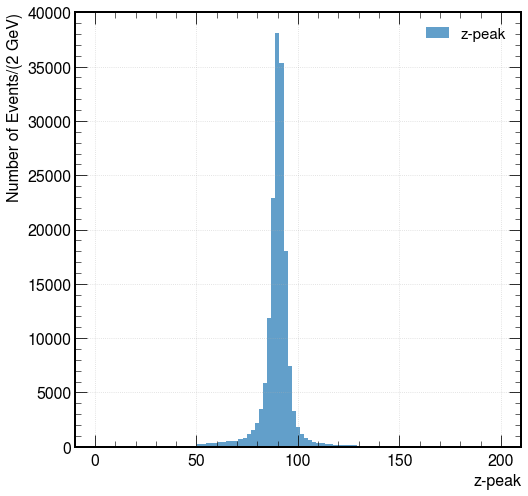

In [43]:
draw(diele.mass,"z-peak",0,200,100)

### #8 Draw hist (2) Coffea

In [38]:
import coffea.hist as hist

In [39]:
histo = hist.Hist("Counts",
                  hist.Cat("dataset", "dataset"),
                  hist.Bin("zmass", "zmass", 100, 0, 200),
                 )

In [40]:
histo.fill(dataset='dataset',zmass=diele.mass)

Text(0.5, 1.0, 'Z-peak')

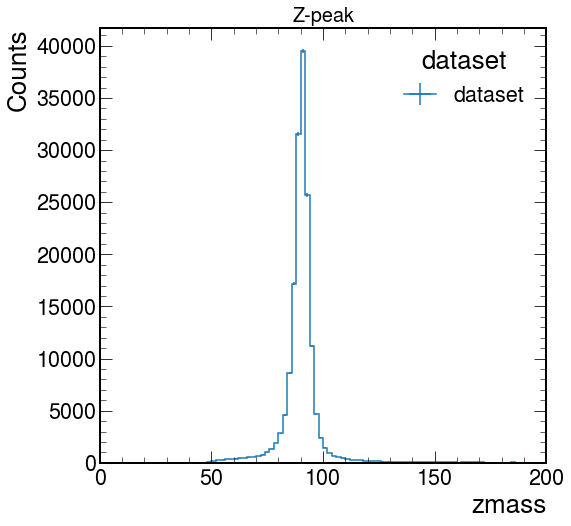

In [41]:
plt.rcParams["figure.figsize"] = (8,8)
hist.plot1d(histo['dataset'])
plt.title('Z-peak',fontsize=20)

### #9. Draw hist (2) Coffea-multi dimension axes

In [29]:
# Define histogram:  Multiple regions with multiple Cat
histo = hist.Hist("Counts",
                  hist.Cat("dataset", "dataset"),
                  hist.Cat("region","region"),
                  hist.Bin("zmass", "zmass", 100, 0, 200),
                 )

In [31]:
SR_mask = (diele.mass > 60) & (diele.mass < 120)
CR_mask = ~SR_mask

In [32]:
SR_mass_arr = diele.mass[SR_mask]
CR_mass_arr = diele.mass[CR_mask]

In [34]:
regions = ['SR','CR']
zmass = {'SR': SR_mass_arr, 'CR': CR_mass_arr}

In [35]:
# Loop over regions and fill hist
for region in regions:
    histo.fill(dataset='dataset',region=region, zmass=zmass[region])

Text(0.5, 1.0, 'Signal region')

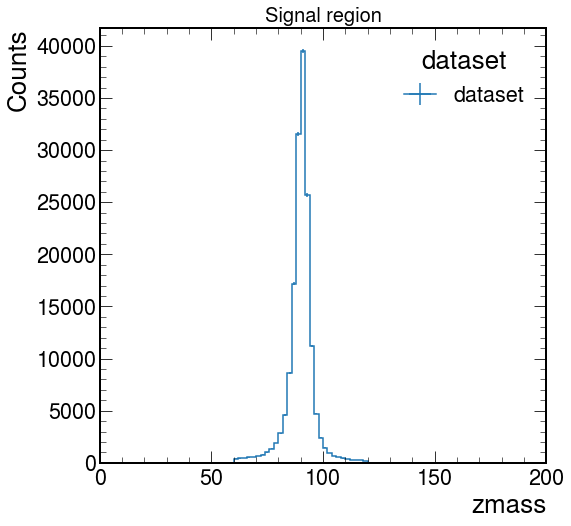

In [36]:
plt.rcParams["figure.figsize"] = (8,8)
hist.plot1d(histo['dataset'].integrate('region','SR'))
plt.title('Signal region',fontsize=20)

Text(0.5, 1.0, 'Control region')

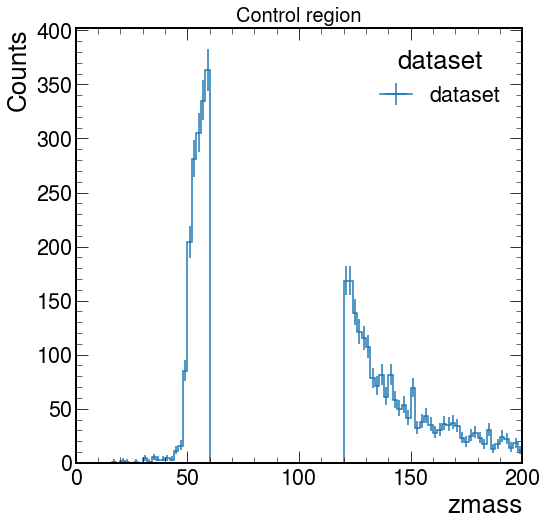

In [37]:

plt.close()
hist.plot1d(histo['dataset'].integrate('region','CR'))
plt.title('Control region',fontsize=20)